## In text classification tasks, we can also make use of the non-textual information to classify the text. For instance, gender may have an impact on the sentiment of the review. Furthermore, nationalities may affect the public opinion about a particular movie. Therefore, this associated info, also known as meta data can also be used to improve accuracy of statistical model.

We will see how to create a text classification system that classifies user reviews regarding different business, into one of the three predefined categories i.e. "good", "bad", and "average". However, in addition to the text of the review, we will use the associated meta data of the review to perform classifcation. Since we have two different types of inputs i.e. textual input and numerical input, we need to create a multiple inputs model. We will be using Keras Functional API since it supports multiple inputs and multiple output models.

### The Dataset

The dataset for this article can be downloaded from this [Kaggle link](https://www.kaggle.com/yelp-dataset/yelp-dataset/version/4#yelp_review.csv). The dataset contains multiple files, but we are only interested in the yelp_review.csv file. The file contains more than 5.2 million reviews about different businesses, including restaurants, bars, dentists, doctors, beauty salons, etc. For our purposes we will only be using the first 50,000 records to train our model.

In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

Using TensorFlow backend.


In [0]:
yelp_reviews = pd.read_csv("yelp_review_short.csv")

The dataset contains a column Stars that contains ratings for different businesses. The "Stars" column can have values between 1 and 5. We will simplify our problem by converting the numerical values for the reviews into categorical ones. We will add a new column reviews_score to our dataset. If the user review has a value of 1 in the Stars column, the reviews_score column will have a string value bad. If the rating is 2 or 3 in the Stars column, the reviews_score column will contain a value average. Finally review rating of 4 or 5 will have a corresponding value of good in the reviews_score column.

In [0]:
bins = [0,1,3,5]
review_names = ['bad', 'average', 'good']
yelp_reviews['reviews_score'] = pd.cut(yelp_reviews['stars'], bins, labels=review_names)

In [4]:
yelp_reviews.isnull().values.any()

print(yelp_reviews.shape)

yelp_reviews.head()

(50000, 10)


,review_id,user_id,business_id,stars,date,text,useful,funny,cool,reviews_score
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,good
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0,good
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0,good
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0,good
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0,good


You can see the 10 columns that our dataframe contains, including the newly added reviews_score column. The text column contains the text of the review while the useful column contains numerical value that represents the count of the people who found the review useful. Similarly, the funny and cool columns contains the counts of people who found reviews funny or cool, respectively.

In [5]:
print(yelp_reviews["text"][3])

Love coming here. Yes the place always needs the floor swept but when you give out  peanuts in the shell how won't it always be a bit dirty. 

The food speaks for itself, so good. Burgers are made to order and the meat is put on the grill when you order your sandwich. Getting the small burger just means 1 patty, the regular is a 2 patty burger which is twice the deliciousness. 

Getting the Cajun fries adds a bit of spice to them and whatever size you order they always throw more fries (a lot more fries) into the bag.


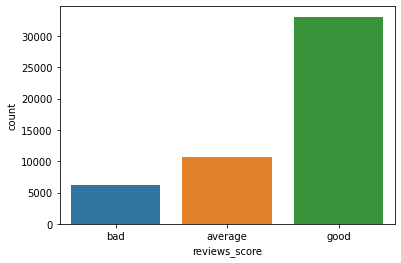

In [6]:
import seaborn as sns

sns.countplot(x='reviews_score', data=yelp_reviews);

We have preprocessed our data and now we will create three models in this article. The first model will only use text inputs for predicting whether a review is good, average, or bad. In the second model, we will not use text. We will only use the meta information such as useful, funny, and cool to predict the sentiment of the review. Finally, we will create a model that accepts multiple inputs i.e. text and meta information for text classification.

## Creating a Model with Text Inputs Only

In [0]:
def preprocess_text(sen):

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [0]:
X = []
sentences = list(yelp_reviews["text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = yelp_reviews['reviews_score']

Our X variable here contains the text reviews while the y variable contains the corresponding reviews_score values. The reviews_score column has data in the text format. We need to convert the text to a one-hot encoded vector. We can use the to_categorical method from the keras.utils module. However, first we have to convert the text into integer labels using the LabelEncoder function from the sklearn.preprocessing module.

In [0]:
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
y = label_encoder.fit_transform(y)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Sentences can have different lengths, and therefore the sequences returned by the Tokenizer class also consist of variable lengths. We specify that maximum length of the sequence will be 200 (although you can try any number). For the sentences having length less than 200, the remaining indexes will be padded with zeros. For the sentences having length greater than 200, the remaining indexes will be truncated.

In [0]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [14]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

NameError: ignored

In [0]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [0]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(3, activation='softmax')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [0]:
print(model.summary())

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

In [0]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

In [0]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Creating a Model with Meta Information Only

In this section, we will create a classification model that uses information from the useful, funny, and cool columns of the yelp reviews. Since the data for these columns is well structured and doesn't contain any sequential or spatial pattern, we can use simple densly connected neural networks to make predictions.

In [0]:
import seaborn as sns
sns.barplot(x='reviews_score', y='useful', data=yelp_reviews);

In [0]:
sns.barplot(x='reviews_score', y='funny', data=yelp_reviews);

In [0]:
sns.barplot(x='reviews_score', y='cool', data=yelp_reviews);

In [0]:
yelp_reviews_meta = yelp_reviews[['useful', 'funny', 'cool']]

X = yelp_reviews_meta.values

y = yelp_reviews['reviews_score']

In [0]:
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
input2 = Input(shape=(3,))
dense_layer_1 = Dense(10, activation='relu')(input2)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)
output = Dense(3, activation='softmax')(dense_layer_2)

model = Model(inputs=input2, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [0]:
print(model.summary())

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

In [0]:
history = model.fit(X_train, y_train, batch_size=16, epochs=10, verbose=1, validation_split=0.2)

In [0]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Creating a Model with Multiple Inputs

In the previous sections, we saw how to train deep learning models using either textual data or meta information. What if we want to combine textual information with meta information and use that as input to our model? We can do so using the Keras functional API. In this section we will create two submodels.

The first submodel will accept textual input in the form of text reviews. This submodel will consist of an input shape layer, an embedding layer, and an LSTM layer of 128 neurons. The second submodel will accept input in the form of meta information from the useful, funny, and cool columns. The second submodel also consist of three layers. An input layer and two dense layers.

The output from the LSTM layer of the first submodel and the output from the second dense layer of the second submodel will be concatenated together and will be used as concatenated input to another dense layer with 10 neurons. Finally, the output dense layer will have three neuorns corresponding to each review type.

In [0]:
X = yelp_reviews.drop('reviews_score', axis=1)

y = yelp_reviews['reviews_score']

In [0]:
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
X1_train = []
sentences = list(X_train["text"])
for sen in sentences:
    X1_train.append(preprocess_text(sen))

In [0]:
X1_test = []
sentences = list(X_test["text"])
for sen in sentences:
    X1_test.append(preprocess_text(sen))

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X1_train)

X1_train = tokenizer.texts_to_sequences(X1_train)
X1_test = tokenizer.texts_to_sequences(X1_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X1_train = pad_sequences(X1_train, padding='post', maxlen=maxlen)
X1_test = pad_sequences(X1_test, padding='post', maxlen=maxlen)

In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [0]:
X2_train = X_train[['useful', 'funny', 'cool']].values
X2_test = X_test[['useful', 'funny', 'cool']].values

In [22]:
input_1 = Input(shape=(maxlen,))

input_2 = Input(shape=(3,))

In [23]:
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer_1 = LSTM(128)(embedding_layer)

In [0]:
dense_layer_1 = Dense(10, activation='relu')(input_2)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)

In [0]:
concat_layer = Concatenate()([LSTM_Layer_1, dense_layer_2])
dense_layer_3 = Dense(10, activation='relu')(concat_layer)
output = Dense(3, activation='softmax')(dense_layer_3)
model = Model(inputs=[input_1, input_2], outputs=output)

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 100)     5572900     input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10)           40          input_2[0][0]                    
__________________________________________________________________________________________

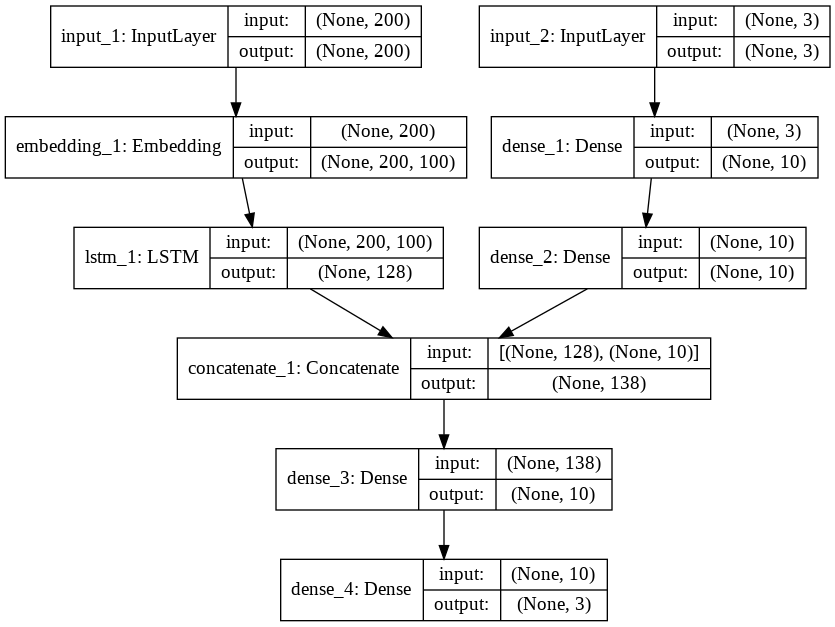

In [27]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

In [28]:
history = model.fit(x=[X1_train, X2_train], y=y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 145s 5ms/step - loss: 0.8496 - acc: 0.6582 - val_loss: 0.8133 - val_acc: 0.6750
Epoch 2/10
32000/32000 [==============================] - 143s 4ms/step - loss: 0.8299 - acc: 0.6639 - val_loss: 0.8192 - val_acc: 0.6694
Epoch 3/10
32000/32000 [==============================] - 144s 4ms/step - loss: 0.8166 - acc: 0.6681 - val_loss: 0.8155 - val_acc: 0.6684
Epoch 4/10
32000/32000 [==============================] - 143s 4ms/step - loss: 0.7644 - acc: 0.6826 - val_loss: 0.6034 - val_acc: 0.7459
Epoch 5/10
32000/32000 [==============================] - 145s 5ms/step - loss: 0.5500 - acc: 0.7623 - val_loss: 0.5206 - val_acc: 0.7760
Epoch 6/10
32000/32000 [==============================] - 142s 4ms/step - loss: 0.5042 - acc: 0.7826 - val_loss: 0.4977 - val_acc: 0.7900
Epoch 7/10
32000/32000 [===

In [0]:
score = model.evaluate(x=[X1_test, X2_test], y=y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()